# SMAI Assignment - 2

## Question 1: Naive Bayes and Clustering

### Part 1: Naive Bayes

[Files](https://drive.google.com/drive/folders/1OUVrOMp2jSSBDJSqvEyXDFTrhiyZnqit?usp=sharing)

You will be performing Sentiment Analysis on a product review dataset with reviews from customers and star rating belonging to four classes (1,2,4,5). You can use sklearn for this question. Your tasks are as follows:

1.   Clean the text by removing punctations and preprocess them using techniques such as stop word removal, stemming etc. You can explore anything!
1.  Create BoW features using the word counts. You can choose the words that form the features such that the performance is optimised. Use the train-test split provided in `train_test_index.pickle` and report any interesting observations based on metrics such as accurarcy, precision, recall and f1 score (You can use Classification report in sklearn).
1. Repeat Task 2 with TfIdf features.

In [12]:
import pickle
with open('train_test_index.pickle', 'rb') as handle:
    train_test_index_dict = pickle.load(handle)

In [13]:
import pandas as pd

data = pd.read_csv('product_reviews.csv')
data.head()

,text,stars,sentiment
0,Total bill for this horrible service? Over $8G...,1.0,0
1,Went in for a lunch. Steak sandwich was delici...,5.0,1
2,This place has gone down hill. Clearly they h...,1.0,0
3,"Walked in around 4 on a Friday afternoon, we s...",1.0,0
4,Michael from Red Carpet VIP is amazing ! I rea...,4.0,1


# **Data Analysis**

In [14]:
data.shape

(26661, 3)

In [15]:
import numpy as np

empty_or_null = data.replace('', np.nan).isnull().any(axis=1)
rows_with_empty_or_null = data[empty_or_null]

print(rows_with_empty_or_null)

Empty DataFrame
Columns: [text, stars, sentiment]
Index: []


*From this, we are assured that there are no empty or null or NaN rows in our data.*

In [16]:
data['stars'].value_counts()

5.0    15397
4.0     6003
1.0     3481
2.0     1780
Name: stars, dtype: int64

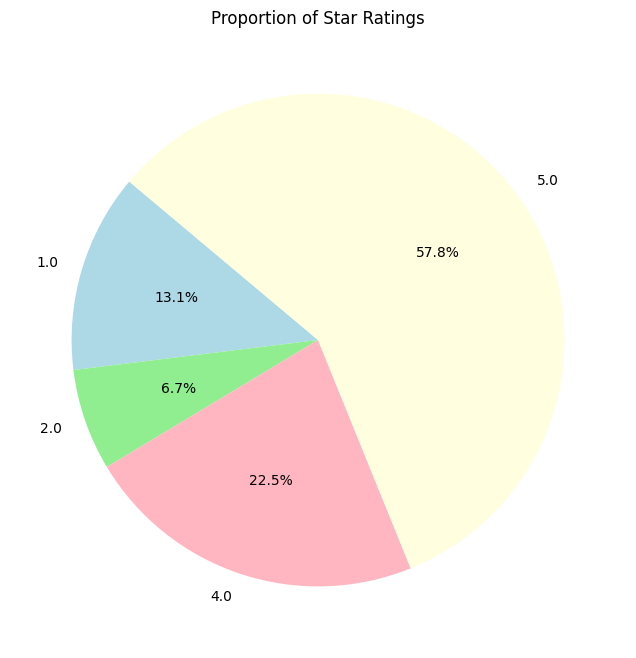

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

stars_count = data['stars'].value_counts()

stars_count = stars_count.sort_index()

plt.figure(figsize=(8, 8))
plt.pie(stars_count, labels=stars_count.index, autopct='%1.1f%%', startangle=140, colors=['lightblue', 'lightgreen', 'lightpink', 'lightyellow'])

plt.title('Proportion of Star Ratings')

plt.show()

*From the above graph, we observe that almost 58% rows contain 5 stars rating which is highest. Lowest is 2 stars rating with percentage almost aroung 7%.*

In [18]:
data['length'] = data['text'].apply(len)

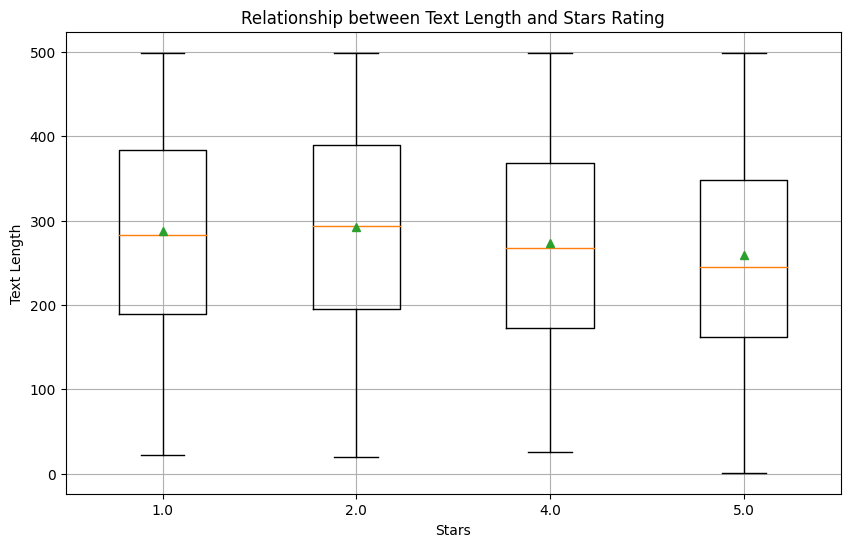

In [19]:
import matplotlib.pyplot as plt

def plot_text_length_distribution(data):
  plt.figure(figsize=(10, 6))

  clubbedData = [data[data['stars'] == star_rating]['length'] for star_rating in sorted(data['stars'].unique())]

  plt.boxplot(clubbedData, showmeans=True)

  plt.xticks(range(1, len(clubbedData) + 1), sorted(data['stars'].unique()))

  plt.title('Relationship between Text Length and Stars Rating')
  plt.xlabel('Stars')
  plt.ylabel('Text Length')
  plt.grid(True)
  plt.show()

plot_text_length_distribution(data)

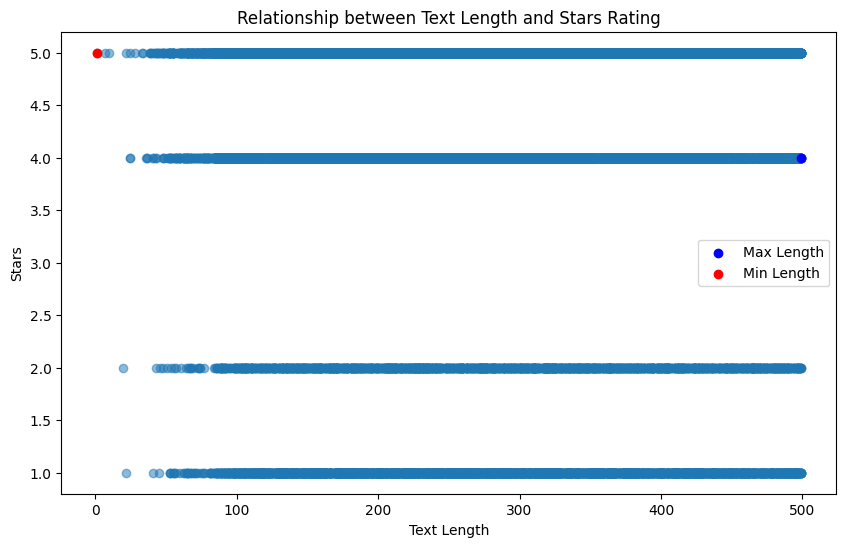

In [20]:
import matplotlib.pyplot as plt

def plot_text_length_vs_stars(data):
  plt.figure(figsize=(10, 6))
  plt.scatter(data['length'], data['stars'], alpha=0.5)

  min_length_index = data['length'].idxmin()
  max_length_index = data['length'].idxmax()

  plt.scatter(data.loc[max_length_index, 'length'], data.loc[max_length_index, 'stars'], color='blue', label='Max Length')
  plt.scatter(data.loc[min_length_index, 'length'], data.loc[min_length_index, 'stars'], color='red', label='Min Length')

  plt.title('Relationship between Text Length and Stars Rating')
  plt.xlabel('Text Length')
  plt.ylabel('Stars')

  plt.legend()
  plt.show()

plot_text_length_vs_stars(data)


*From the above graphs, we observe that text length is slightly more for less rating. That means text length and star ratings might be inversely related.*

In [21]:
!pip install langdetect

In [11]:
import pandas as pd
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException

data['language'] = data['text'].apply(lambda text: detect(text) if not pd.isnull(text) else 'unknown')
non_english_df = data[data['language'] != 'en']

print(non_english_df.shape)
print(non_english_df.head())

(152, 5)
                                                   text  stars  sentiment  \
311   Un genre de "self serve" de pâtisseries hongko...    4.0          1   
522   Excellente place que vous passiez juste prendr...    4.0          1   
601   Un des meilleurs endroits découvert à ce jour ...    5.0          1   
1198  Meilleure pizza dans le coin à date. Cependant...    4.0          1   
1474  Petite boutique d'objets vintages et antiques....    5.0          1   

      length language  
311      462       fr  
522      320       fr  
601      273       fr  
1198     413       fr  
1474     201       fr  


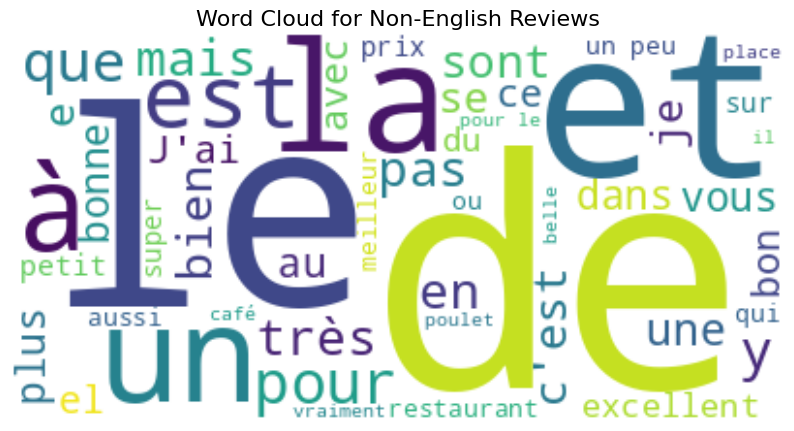

In [22]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

reviews = " ".join(non_english_df['text'])

wc = WordCloud(background_color='white', max_words=50)

wordcloud = wc.generate(reviews)

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Non-English Reviews', fontsize=16)
plt.axis('off')
plt.show()


*We observe that the text review contains some non english words which should be removed while pre-precessing the data.*

# **Data pre-processing**

In [23]:
!pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 6.4 MB/s eta 0:00:00


In [25]:
from langdetect import detect, LangDetectException
import re
from nltk.corpus import stopwords
import contractions
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import nltk
from nltk.corpus import words
from nltk.stem import WordNetLemmatizer

In [26]:
nltk.download('punkt')
nltk.download('words')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [27]:
english_words_set = set(words.words())

stop_words = set(stopwords.words('english'))

ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def data_preprocessing(text):
  text = contractions.fix(text)
  text = re.sub(r'[^a-zA-Z0-9\s]', '', text).lower()

  tokens = word_tokenize(text)

  tokens_english = [word for word in tokens if word in english_words_set]

  tokens_no_stop = [word for word in tokens_english if word not in stop_words]

  stemmed_tokens = [ps.stem(word) for word in tokens_no_stop]

  lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens_no_stop]

  final_stemmed = ' '.join(stemmed_tokens)
  final_lemmatized = ' '.join(lemmatized_tokens)

  return final_stemmed, final_lemmatized

data['final_stemmed'], data['final_lemmatized'] = zip(*data['text'].apply(data_preprocessing))

print(data.head())


                                                text  stars  sentiment  \
0  Total bill for this horrible service? Over $8G...    1.0          0   
1  Went in for a lunch. Steak sandwich was delici...    5.0          1   
2  This place has gone down hill.  Clearly they h...    1.0          0   
3  Walked in around 4 on a Friday afternoon, we s...    1.0          0   
4  Michael from Red Carpet VIP is amazing ! I rea...    4.0          1   

   length                                      final_stemmed  \
0     204  total bill horribl servic actual nerv charg us...   
1     407  went lunch steak sandwich delici salad absolut...   
2     374  place gone hill clearli cut back staff food qu...   
3     434  around afternoon sat tabl bar min even think h...   
4     447  red carpet amaz help soon sister group littl s...   

                                    final_lemmatized  
0  total bill horrible service actually nerve cha...  
1  went lunch steak sandwich delicious salad abso...  
2  pl

In [30]:
train_index = train_test_index_dict['train_index']
test_index = train_test_index_dict['test_index']

# **Bag of Words**

In [32]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [35]:
pip install matplotlib seaborn scikit-learn

***with stemming and MultinomialNB***

In [31]:
count_vectorizer = CountVectorizer()
X_count = count_vectorizer.fit_transform(data['final_stemmed'])

X_train_count, X_test_count = X_count[train_index], X_count[test_index]
y_train, y_test = data['stars'][train_index], data['stars'][test_index]

naive_bayes_count = MultinomialNB()
naive_bayes_count.fit(X_train_count, y_train)
y_pred_count = naive_bayes_count.predict(X_test_count)
print("Classification Report for BoW (CountVectorizer) with stemming and MultinomialNB:\n", classification_report(y_test, y_pred_count))

Classification Report for BoW (CountVectorizer) with stemming and MultinomialNB:
               precision    recall  f1-score   support

         1.0       0.72      0.75      0.74      1149
         2.0       0.41      0.20      0.27       587
         4.0       0.48      0.54      0.51      1981
         5.0       0.80      0.80      0.80      5082

    accuracy                           0.70      8799
   macro avg       0.60      0.57      0.58      8799
weighted avg       0.69      0.70      0.69      8799



1. The model excels at identifying extreme sentiments (1.0 & 5.0) with high accuracy, indicating effective handling of clear positive and negative expressions.
2. Performance drops significantly for middle classes (2.0 & 4.0), suggesting challenges in distinguishing nuanced sentiments.
3. Overall accuracy stands at 70%, showing competency yet highlighting room for improvement, especially for classes with subtle distinctions.
4. Class imbalance affects performance metrics, with a bias towards classes having more samples (e.g., class 5.0).
5. Macro vs. weighted averages reveal the impact of class imbalance, with macro averages lower due to equal treatment of all classes regardless of their sample size.

In [34]:
print("Accuracy:", accuracy_score(y_test, y_pred_count))
print("Recall:", recall_score(y_test, y_pred_count, average='macro'))
print("F1 Score:", f1_score(y_test, y_pred_count, average='macro'))
print("Precision:", precision_score(y_test, y_pred_count, average='macro'))

Accuracy: 0.695988180475054
Recall: 0.572377304907421
F1 Score: 0.57780097455877
Precision: 0.603439637901802


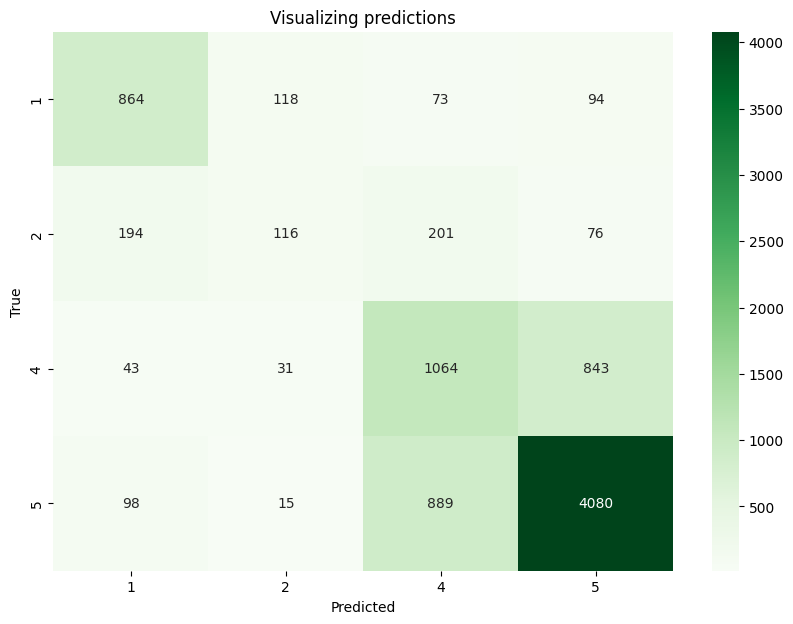

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

predictions = y_pred_count

cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=[1, 2, 4, 5], yticklabels=[1, 2, 4, 5])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Visualizing predictions')
plt.show()

***with lemmatization and MultinomialNB***

In [38]:
count_vectorizer = CountVectorizer()
X_count = count_vectorizer.fit_transform(data['final_lemmatized'])

X_train_count, X_test_count = X_count[train_index], X_count[test_index]
y_train, y_test = data['stars'][train_index], data['stars'][test_index]

naive_bayes_count = MultinomialNB()
naive_bayes_count.fit(X_train_count, y_train)
y_pred_count = naive_bayes_count.predict(X_test_count)
print("Classification Report for BoW (CountVectorizer) with lemmatization and MultinomialNB:\n", classification_report(y_test, y_pred_count))

Classification Report for BoW (CountVectorizer) with lemmatization and MultinomialNB:
               precision    recall  f1-score   support

         1.0       0.73      0.76      0.74      1149
         2.0       0.41      0.17      0.24       587
         4.0       0.48      0.54      0.51      1981
         5.0       0.80      0.81      0.81      5082

    accuracy                           0.70      8799
   macro avg       0.61      0.57      0.58      8799
weighted avg       0.69      0.70      0.69      8799



1. Lemmatization slightly improves precision and recall for strongly negative sentiments (class 1.0), indicating a better handling of negative expressions compared to stemming.
2. Performance for slightly negative sentiments (class 2.0) decreases, especially in recall, suggesting lemmatization might miss some nuanced negative sentiments.
3. For neutral and positive classes (4.0 and 5.0), performance metrics are stable, showing lemmatization's consistent effectiveness across different sentiments.
4. The overall model accuracy remains at 70%, implying that the choice between lemmatization and stemming does not drastically alter the model's general classification capability.
5. The slight shifts in performance metrics with lemmatization suggest a nuanced impact on text normalization, particularly benefiting the detection of strong negative sentiments.

In [39]:
print("Accuracy:", accuracy_score(y_test, y_pred_count))
print("Precision:", precision_score(y_test, y_pred_count, average='macro'))
print("Recall:", recall_score(y_test, y_pred_count, average='macro'))
print("F1 Score:", f1_score(y_test, y_pred_count, average='macro'))

Accuracy: 0.6992840095465394
Precision: 0.6058405590382996
Recall: 0.5695691681026422
F1 Score: 0.5750572236266913


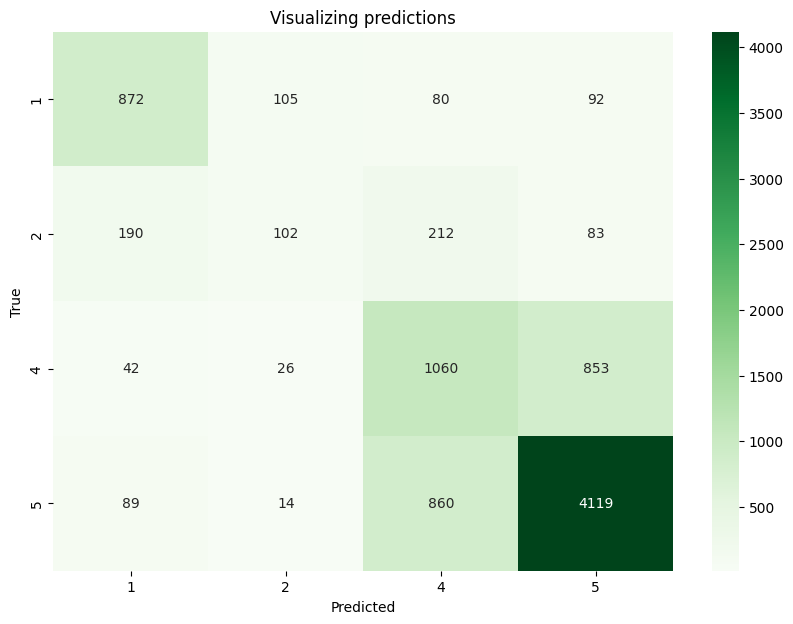

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

predictions = y_pred_count

cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=[1, 2, 4, 5], yticklabels=[1, 2, 4, 5])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Visualizing predictions')
plt.show()

***with stemming and ComplementNB***

In [42]:
from sklearn.naive_bayes import ComplementNB


X_count = count_vectorizer.fit_transform(data['final_stemmed'])

X_train_count, X_test_count = X_count[train_index], X_count[test_index]
y_train, y_test = data['stars'][train_index], data['stars'][test_index]

complement_nb = ComplementNB()
complement_nb.fit(X_train_count, y_train)
y_pred_complement = complement_nb.predict(X_test_count)

print("Classification Report for BoW (CountVectorizer) with stemming and ComplementNB:\n", classification_report(y_test, y_pred_complement))

Classification Report for BoW (CountVectorizer) with stemming and ComplementNB:
               precision    recall  f1-score   support

         1.0       0.59      0.88      0.71      1149
         2.0       0.40      0.17      0.23       587
         4.0       0.51      0.46      0.49      1981
         5.0       0.82      0.81      0.81      5082

    accuracy                           0.70      8799
   macro avg       0.58      0.58      0.56      8799
weighted avg       0.69      0.70      0.69      8799



1. ComplementNB significantly improves recall for strongly negative sentiments (class 1.0), indicating enhanced sensitivity to negative content but potentially at the cost of more false positives.
2. The model shows limited effectiveness in recognizing slightly negative sentiments (class 2.0) with low recall, suggesting challenges in capturing nuanced negativity.
3. Moderate success in identifying neutral sentiments (class 4.0) with a balanced precision and recall, indicating an average ability to distinguish neutral from extreme sentiments.
4. High precision and recall for strongly positive sentiments (class 5.0) demonstrate the model's proficiency in recognizing clear positive expressions.
5. Overall accuracy remains consistent at 70%, indicating that the change to ComplementNB does not significantly impact the model's general classification ability.
6. The shift towards higher recall in some classes suggests ComplementNB's advantage in handling imbalanced datasets, prioritizing the identification of positive and negative sentiments over precision.

In [43]:
print("Accuracy:", accuracy_score(y_test, y_pred_complement))
print("Precision:", precision_score(y_test, y_pred_complement, average='macro'))
print("Recall:", recall_score(y_test, y_pred_complement, average='macro'))
print("F1 Score:", f1_score(y_test, y_pred_complement, average='macro'))

Accuracy: 0.6978065689282873
Precision: 0.5781895841168575
Recall: 0.5797481948954226
F1 Score: 0.559497633652108


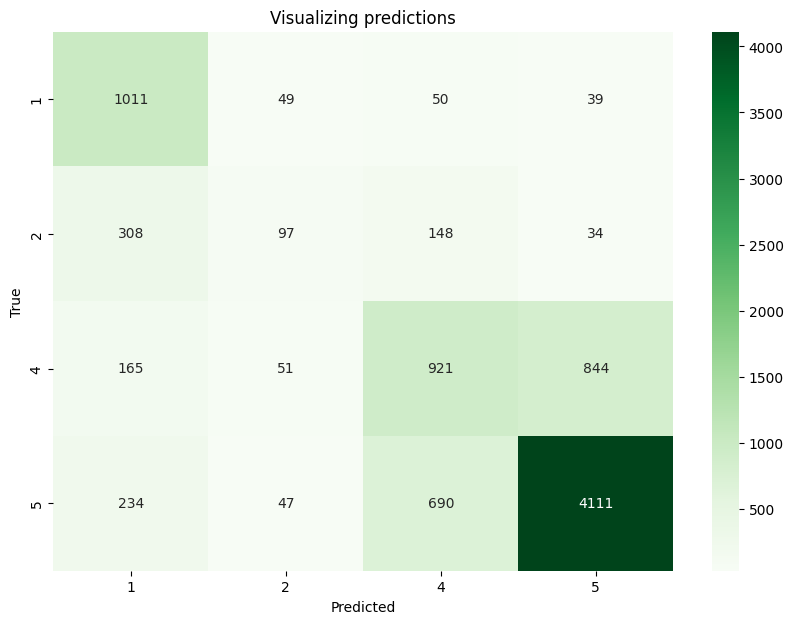

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

predictions = y_pred_complement

cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=[1, 2, 4, 5], yticklabels=[1, 2, 4, 5])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Visualizing predictions')
plt.show()

***with lemmatization and ComplementNB***

In [45]:
from sklearn.naive_bayes import ComplementNB


X_count = count_vectorizer.fit_transform(data['final_lemmatized'])

X_train_count, X_test_count = X_count[train_index], X_count[test_index]
y_train, y_test = data['stars'][train_index], data['stars'][test_index]

complement_nb = ComplementNB()
complement_nb.fit(X_train_count, y_train)
y_pred_complement = complement_nb.predict(X_test_count)

print("Classification Report for BoW (CountVectorizer) with lemmatization  and ComplementNB:\n", classification_report(y_test, y_pred_complement))

Classification Report for BoW (CountVectorizer) with lemmatization  and ComplementNB:
               precision    recall  f1-score   support

         1.0       0.59      0.88      0.71      1149
         2.0       0.42      0.18      0.25       587
         4.0       0.51      0.45      0.48      1981
         5.0       0.82      0.82      0.82      5082

    accuracy                           0.70      8799
   macro avg       0.59      0.58      0.56      8799
weighted avg       0.69      0.70      0.69      8799



1. High recall for class 1.0 with lemmatization and ComplementNB indicates strong detection of strongly negative sentiments.
2. Lemmatization slightly improves detection of subtle negative sentiments (class 2.0), with small gains in precision and recall.
3. Performance for neutral (class 4.0) and positive (class 5.0) sentiments remains stable, showing effective sentiment identification across the spectrum.
4. The overall accuracy of the model is consistent at 70%, reflecting no significant impact from switching between stemming and lemmatization.
5. Lemmatization with ComplementNB marginally enhances the model's ability to differentiate between very negative and slightly negative sentiments.
6. The model demonstrates a balanced ability to accurately identify strongly positive sentiments (class 5.0), leveraging the strengths of lemmatization.

In [46]:
print("Accuracy:", accuracy_score(y_test, y_pred_complement))
print("Precision:", precision_score(y_test, y_pred_complement, average='macro'))
print("Recall:", recall_score(y_test, y_pred_complement, average='macro'))
print("F1 Score:", f1_score(y_test, y_pred_complement, average='macro'))

Accuracy: 0.7012160472780998
Precision: 0.585797873076762
Recall: 0.5810395194696781
F1 Score: 0.5634748845345561


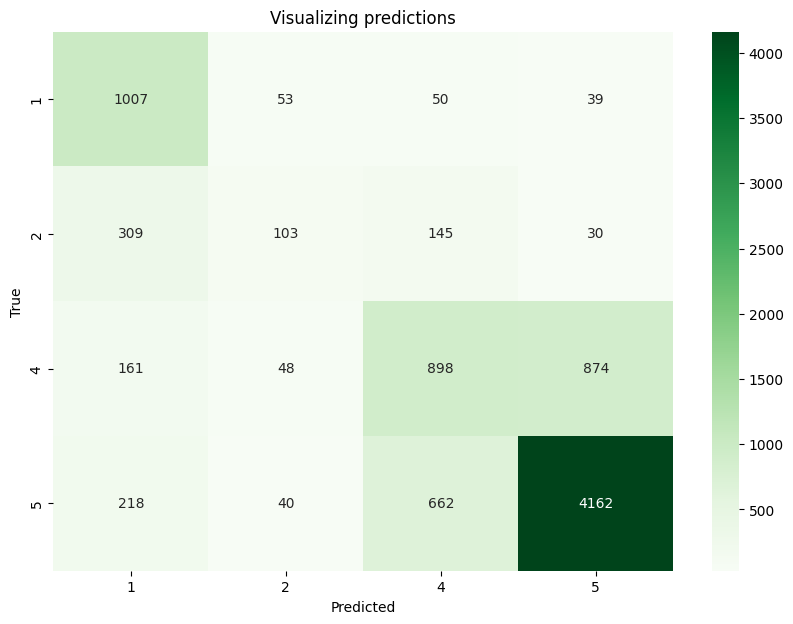

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

predictions = y_pred_complement

cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=[1, 2, 4, 5], yticklabels=[1, 2, 4, 5])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Visualizing predictions')
plt.show()

# **tf-idf**

***tf-idf with stemming***

In [49]:
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(data['final_stemmed'])

X_train_tfidf, X_test_tfidf = X_tfidf[train_index], X_tfidf[test_index]
y_train, y_test = data['stars'][train_index], data['stars'][test_index]

clf_tfidf = MultinomialNB()
clf_tfidf.fit(X_train_tfidf, y_train)

predictions_tfidf = clf_tfidf.predict(X_test_tfidf)

print("Classification Report for tf-idf (TfidfVectorizer) with lemmatization:\n", classification_report(y_test, predictions_tfidf))

Classification Report for tf-idf (TfidfVectorizer) with lemmatization:
               precision    recall  f1-score   support

         1.0       0.90      0.31      0.46      1149
         2.0       0.00      0.00      0.00       587
         4.0       0.48      0.05      0.09      1981
         5.0       0.62      0.99      0.76      5082

    accuracy                           0.63      8799
   macro avg       0.50      0.34      0.33      8799
weighted avg       0.58      0.63      0.52      8799



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1. Indicates the model can accurately identify strongly negative sentiments when it does predict them, but it often fails to detect many of these cases.
2. The model completely fails to identify any instances of slightly negative sentiments, showing a critical weakness in detecting nuanced negative feedback.
3. Demonstrates the model's significant struggle with identifying neutral sentiments, with extremely low recall and poor f1-score.
4. The model heavily favors detecting strongly positive sentiments, with very high recall but lower precision, suggesting a bias towards classifying texts as positive.
5. Compared to previous models, there's a noticeable drop in overall accuracy and f1-scores across classes, indicating that TF-IDF with lemmatization in this context might not be as effective in balanced sentiment classification.

***tf-idf with lemmatization***

In [50]:
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(data['final_lemmatized'])

X_train_tfidf, X_test_tfidf = X_tfidf[train_index], X_tfidf[test_index]
y_train, y_test = data['stars'][train_index], data['stars'][test_index]

clf_tfidf = MultinomialNB()
clf_tfidf.fit(X_train_tfidf, y_train)

predictions_tfidf = clf_tfidf.predict(X_test_tfidf)

print("Classification Report for tf-idf (TfidfVectorizer) with lemmatization:\n", classification_report(y_test, predictions_tfidf))

Classification Report for tf-idf (TfidfVectorizer) with lemmatization:
               precision    recall  f1-score   support

         1.0       0.89      0.28      0.42      1149
         2.0       0.00      0.00      0.00       587
         4.0       0.50      0.05      0.09      1981
         5.0       0.61      0.99      0.76      5082

    accuracy                           0.62      8799
   macro avg       0.50      0.33      0.32      8799
weighted avg       0.58      0.62      0.51      8799



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1. High precision but very low recall for class 1.0 suggests the model is precise but misses many negative instances.
2. The model's failure to identify class 2.0 (zero precision and recall) highlights a significant gap in detecting subtle negativity.
3. The model struggles significantly with class 4.0, showing it has difficulty recognizing neutral sentiments.
4. The model shows a strong preference for classifying texts as strongly positive, with very high recall but compromised precision.
5. The overall accuracy and f1-scores are lower than previous models, indicating that TF-IDF with lemmatization may not be as effective for this task.

### Part 2: Clustering

You will be performing kmeans clustering on the same product reviews dataset from Part 1. In this question, instead of statistically computing features, you will use the embeddings obtained from a neural sentiment analysis model (huggingface: siebert/sentiment-roberta-large-english).

You can use sklearn for this question. Your tasks are as follows:


1. Perform kmeans clustering using sklearn. Try various values for number of clusters (k) and plot the elbow curve. For each value of k, plot WCSS (Within-Cluster Sum of Square). WCSS is the sum of the squared distance between each point and the centroid in a cluster.
1. Perform task 1 with cluster initialisation methods [k-means++, forgy ("random" in sklearn)].
1. In this case, since the ground truth labels (star rating) are available we can evaluate the clustering using metrics like purity, nmi and rand score. Implement these metrics from scratch and evaluate the clustering. [Reference](https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-clustering-1.html)

In [5]:
import gzip
import numpy as np

f = gzip.GzipFile('roberta_embeds.npy.gz', "r")
embeds = np.load(f)
print(embeds.shape)

(26661, 1024)


In [6]:
!pip install kneed

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from kneed import KneeLocator

***implement kmeans***

In [3]:
def implementKmeansClust(k, init_str):
  kmeans = KMeans(n_clusters=k, init=init_str, random_state=0, n_init='auto')
  kmeans.fit(embeds)
  return kmeans

In [2]:
def kmeansClustering(starting_k_value, end_k_value, init_str = 'k-means++'):
  k_values = range(starting_k_value, end_k_value)
  wcss = []
  for k in k_values:
    kmeans = implementKmeansClust(k, init_str)
    wcss.append(kmeans.inertia_)
  kl = KneeLocator(k_values, wcss, curve="convex", direction="decreasing")
  optimal_k = kl.elbow

  print("when starting with k =", starting_k_value, "optimal k value is", optimal_k)

  plt.figure(figsize=(10, 5))
  plt.plot(k_values, wcss, marker='o', linestyle='--')
  plt.title('Elbow Method For Optimal k')
  plt.xlabel('Number of clusters (k)')
  plt.ylabel('WCSS')
  plt.show()

  return wcss

when starting with k = 2 optimal k value is 4


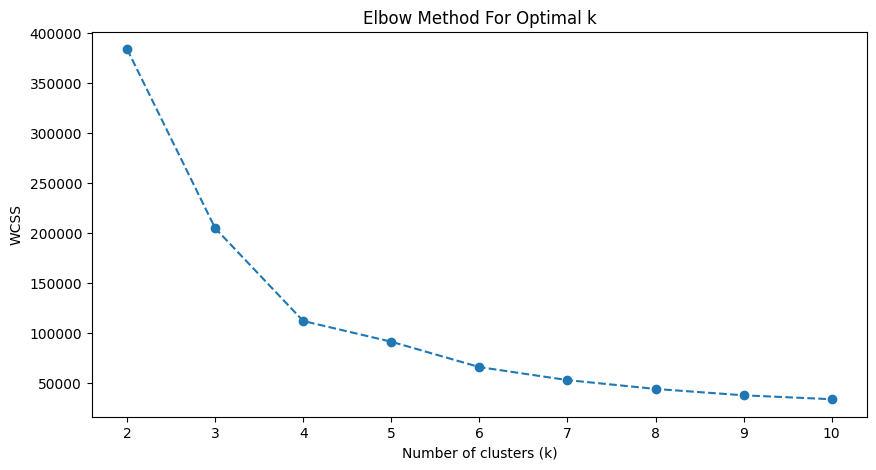

In [55]:
wcss_1 = kmeansClustering(2, 11)

when starting with k = 4 optimal k value is 6


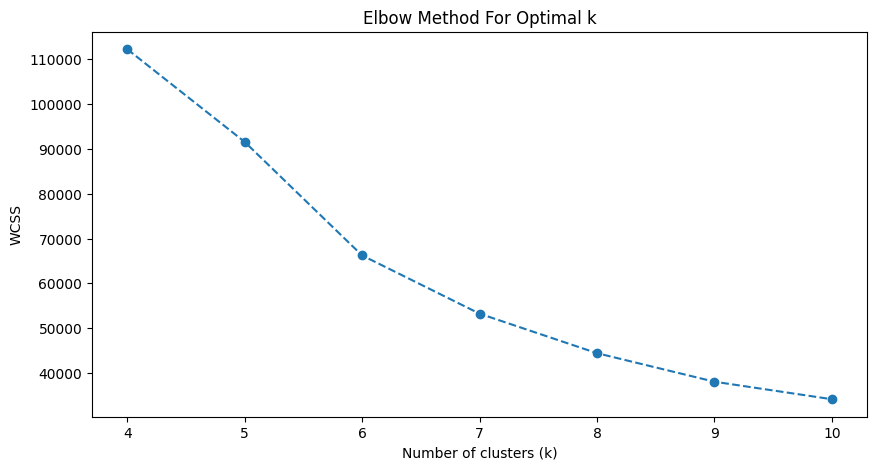

In [56]:
wcss_4 = kmeansClustering(4, 11)

***Forgy***

when starting with k = 2 optimal k value is 4


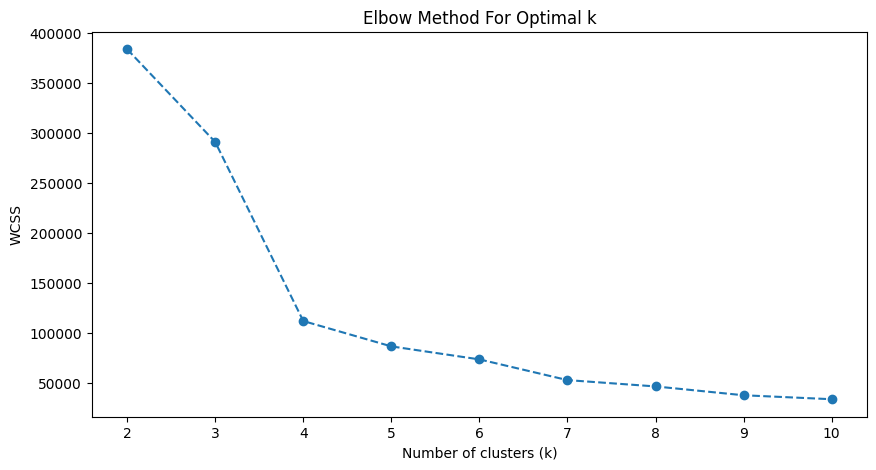

In [7]:
wcss_2 = kmeansClustering(2, 11, 'random')

when starting with k = 4 optimal k value is 7


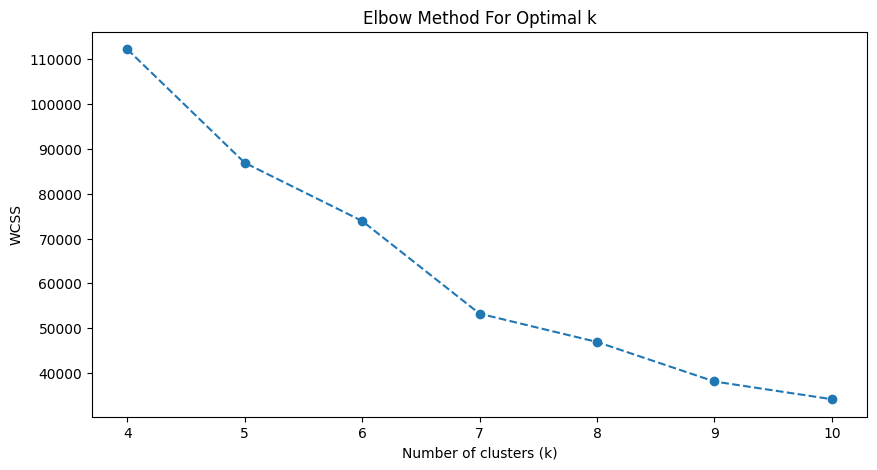

In [8]:
wcss_4 = kmeansClustering(4, 11, 'random')

***clustering with different initialization methods***

In [9]:
optimal_k = 4

In [10]:
kmeansManual = implementKmeansClust(optimal_k, 'k-means++')
labels_kmeans_plus = kmeansManual.labels_
kmeansManual = implementKmeansClust(optimal_k, 'random')
labels_forgy = kmeansManual.labels_

***Evaluate Predictions***

***Purity***

In [11]:
def calculatePurity(cluster_indices):
  total_sum = 0
  for i in range(0, optimal_k):
    stars_at_indices = data.iloc[cluster_indices[i]]['stars']
    star_counts = stars_at_indices.value_counts()
    max_occuring_star_count = star_counts.max()
    max_occuring_star = star_counts.idxmax()
    total_sum += max_occuring_star_count
    print("Cluster", i)
    print("Total length of cluster:", len(cluster_indices[i]))
    print("Maximum occuring star rating:", max_occuring_star)
    print("Count of maximum occuring star rating:", max_occuring_star_count)
    print()
  purity = total_sum / embeds.shape[0]
  print("Purity = ", purity)

kmeans++

In [14]:
cluster_indices = {i: np.where(labels_kmeans_plus == i)[0] for i in range(optimal_k)}
calculatePurity(cluster_indices)

Cluster 0
Total length of cluster: 546
Maximum occuring star rating: 2.0
Count of maximum occuring star rating: 214

Cluster 1
Total length of cluster: 20670
Maximum occuring star rating: 5.0
Count of maximum occuring star rating: 15163

Cluster 2
Total length of cluster: 4855
Maximum occuring star rating: 1.0
Count of maximum occuring star rating: 3311

Cluster 3
Total length of cluster: 590
Maximum occuring star rating: 4.0
Count of maximum occuring star rating: 325

Purity =  0.7131390420464349


kmeans using random

In [15]:
cluster_indices = {i: np.where(labels_forgy == i)[0] for i in range(optimal_k)}
calculatePurity(cluster_indices)

Cluster 0
Total length of cluster: 4855
Maximum occuring star rating: 1.0
Count of maximum occuring star rating: 3311

Cluster 1
Total length of cluster: 546
Maximum occuring star rating: 2.0
Count of maximum occuring star rating: 214

Cluster 2
Total length of cluster: 594
Maximum occuring star rating: 4.0
Count of maximum occuring star rating: 328

Cluster 3
Total length of cluster: 20666
Maximum occuring star rating: 5.0
Count of maximum occuring star rating: 15162

Purity =  0.7132140579873223


***Random score***

In [17]:
from sklearn.metrics import rand_score
ri_score = rand_score(data['stars'], labels_kmeans_plus)
print(f"Rand Index Score using built-in function (kmeans++):", ri_score)
ri_score_2 = rand_score(data['stars'], labels_forgy)
print(f"Rand Index Score using built-in function (kmeans with random):", ri_score_2)

Rand Index Score using built-in function (kmeans++): 0.7275187340775782
Rand Index Score using built-in function (kmeans with random): 0.7275735075323911


In [19]:
import numpy as np
from scipy.special import comb

def rand_index_score(y_true, y_pred):
    tp_plus_fp = np.sum(comb(np.bincount(y_pred.astype(int)), 2))
    tp_plus_fn = np.sum(comb(np.bincount(y_true.astype(int)), 2))

    A = np.c_[y_true, y_pred]

    tp = sum(comb(np.bincount(A[A[:, 0] == i, 1].astype(int)), 2).sum() for i in set(y_true))

    fp = tp_plus_fp - tp
    fn = tp_plus_fn - tp

    tn = comb(len(A), 2) - tp - fp - fn

    return (tp + tn) / (tp + fp + fn + tn)

print("Rand Index score (for kmeans++):", rand_index_score(data['stars'], labels_kmeans_plus))
print("Rand Index score (for random):", rand_index_score(data['stars'], labels_forgy))


Rand Index score (for kmeans++): 0.7275187340775782
Rand Index score (for random): 0.7275735075323911


***NMI***

In [20]:
from sklearn.metrics import normalized_mutual_info_score

nmi_score = normalized_mutual_info_score(data['stars'], labels_kmeans_plus, average_method='arithmetic')
print(f"Normalized Mutual Information (NMI) Score (for kmeans++):", nmi_score)

nmi_score = normalized_mutual_info_score(data['stars'], labels_forgy, average_method='arithmetic')
print(f"Normalized Mutual Information (NMI) Score (for random):", nmi_score)

Normalized Mutual Information (NMI) Score (for kmeans++): 0.5201333809417152
Normalized Mutual Information (NMI) Score (for random): 0.5200273108478978


In [21]:
import numpy as np

def calculate_entropy(labels):
    _, label_counts = np.unique(labels, return_counts=True)
    probabilities = label_counts / label_counts.sum()
    return -np.sum(probabilities * np.log(probabilities))

def calculate_mutual_information(true_labels, predicted_labels):
    mutual_info = 0
    for true_label in np.unique(true_labels):
        for predicted_label in np.unique(predicted_labels):
            intersection = np.logical_and(true_labels == true_label, predicted_labels == predicted_label).sum()
            if intersection > 0:
                p_true = np.sum(true_labels == true_label) / len(true_labels)
                p_predicted = np.sum(predicted_labels == predicted_label) / len(predicted_labels)
                p_intersection = intersection / len(true_labels)
                mutual_info += p_intersection * np.log(p_intersection / (p_true * p_predicted))
    return mutual_info

def calculate_normalized_mutual_information(true_labels, predicted_labels):
    mutual_info = calculate_mutual_information(true_labels, predicted_labels)
    entropy_true = calculate_entropy(true_labels)
    entropy_predicted = calculate_entropy(predicted_labels)
    return mutual_info / np.sqrt(entropy_true * entropy_predicted)

nmi_score = calculate_normalized_mutual_information(data['stars'], labels_kmeans_plus)
print(f"Normalized Mutual Information (NMI) Score (for kmeans++):", nmi_score)

nmi_score = calculate_normalized_mutual_information(data['stars'], labels_forgy)
print(f"Normalized Mutual Information (NMI) Score (for random):", nmi_score)

Normalized Mutual Information (NMI) Score (for kmeans++): 0.5360152452341738
Normalized Mutual Information (NMI) Score (for random): 0.5358546011063245
